## Delay Embeddings

The purpose of this preprocessing is to apply the Mutual Information Criterion (MIC) and the False Nearest Neighbors (FNN) technique to find the optimal values for lags and dimension for delay vector construction of the input time series.
Unfortunately, the data chosen for testing the ANCFIS model don't allow for usage of the optimal lag and delay found here. There is just not enough observations in the chosen series. I include this results for completeness, even though they are not relevant for the specific dataset chosen for testing.

Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from typing import Union

# Finance utils
from pandas_datareader import data as pdr
import yfinance as yfin

In [3]:
# Download data sample
tickers = ["^IXIC"]
start_date = "1970-05-01"
end_date = "2023-03-14"

yfin.pdr_override()
data = pdr.get_data_yahoo(tickers[0],  start=start_date, end=end_date, interval = "1wk")
close = data['Close']
predictor = torch.tensor(close)[:-1]
outcome = torch.tensor(close.shift(-1))[:-1]
train_test_split = 0.8
x = predictor[:round(len(outcome)*train_test_split)]
y = predictor[:round(len(outcome)*train_test_split)]

[*********************100%***********************]  1 of 1 completed


In [4]:
# Define function to create delay vector
def delay_vector(x:np.array, tao, dim):
    delay = []
    for j in range(1,len(x)-tao*dim + tao + 1):
        k = []
        for i in range(dim):
            k.append(x[-1-i*tao])
        x = x[:-1]
        delay.append(k[::-1])
    return np.array(delay[::-1])

delay = delay_vector(close[:100].values, 5, 10)

#### Plot Log returns

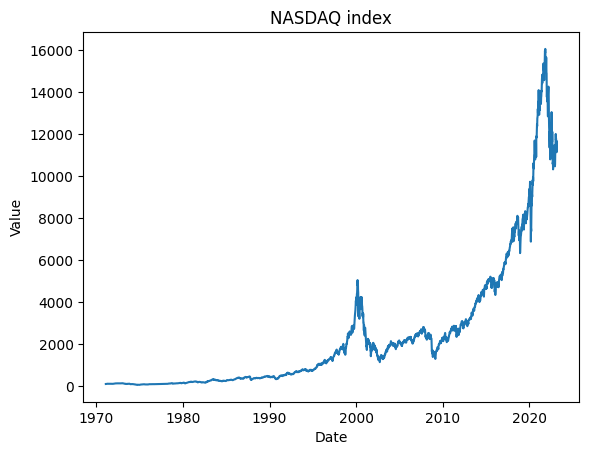

In [5]:
plt.title('NASDAQ index')
plt.xlabel('Date')
plt.ylabel('Value')
plt.plot(close)
plt.savefig('../img/NASDAQ.png')

#### Plot Linear Regression for Log returns

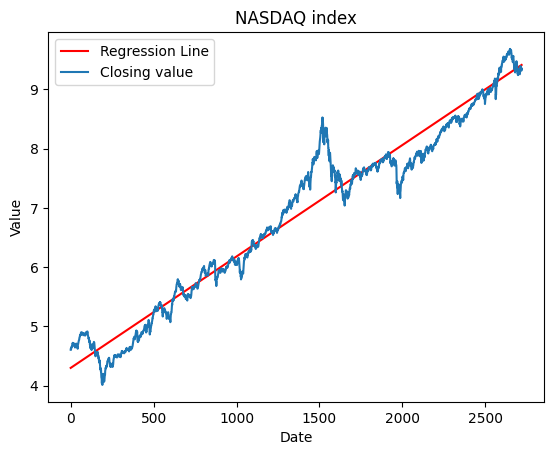

In [6]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.arange(len(x)).reshape(-1,1), np.log(x).reshape(-1,1))
plt.title('NASDAQ index')
plt.xlabel('Date')
plt.ylabel('Value')
plt.plot(reg.predict(np.arange(len(close)).reshape(-1,1)), color = 'red', label = 'Regression Line')
plt.plot(np.log(close.values), label ='Closing value')
plt.legend()
# plt.savefig('../img/NASDAQ_log_regr.png')

# Plot Normalized Data

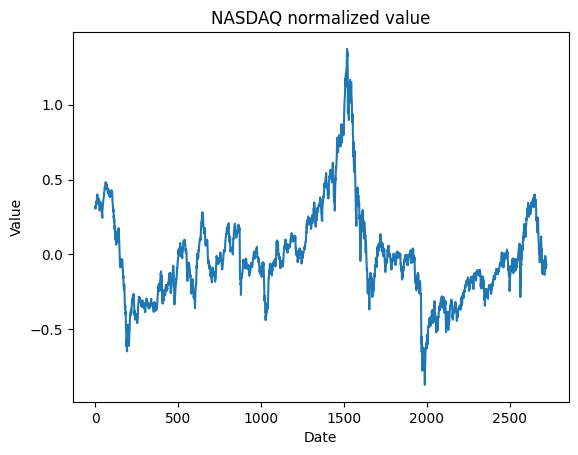

In [7]:
normalized_data = np.log(close.values) - reg.predict(np.arange(len(close)).reshape(-1,1)).reshape(len(close))
plt.title('NASDAQ normalized value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.plot(normalized_data)
# plt.savefig('NASDAQ_Normalized.png')

### Mutual Information Criterion

Mutual Information Criterion is way of estimating the optimal lag for state-phase reconstruction of a time series only using target variable observations. It was first devised by Shaw (1984), while Fraser&Swinney (1986) gave an empirical demonstration of the superiority of the criteria with respect to the first zero of the autocorrelation function. The authors argue that the reason is to be found in the ability of the mutual information function to capture general dependence between variables with respect to the capability of autocorrelation function to only detect linear dependence relationships. <br>
The criterion requires to estimate the probablity distribution for S<sub>n</sub> and the joint probability distribution for S<sub>n-t</sub>.
After that, the Mutual Information Function (MIF) is computed according to the formula:
<br>
$$\sum_{i,j}p_{ij}(t)\ln{p_{ij}(t)}-2\sum_{i}p_i\ln{p_i}$$
<br>
The value of the function is computed for each lag t.
The argument that first minimizes the MIF is chosen as the best delay for the delay vector.

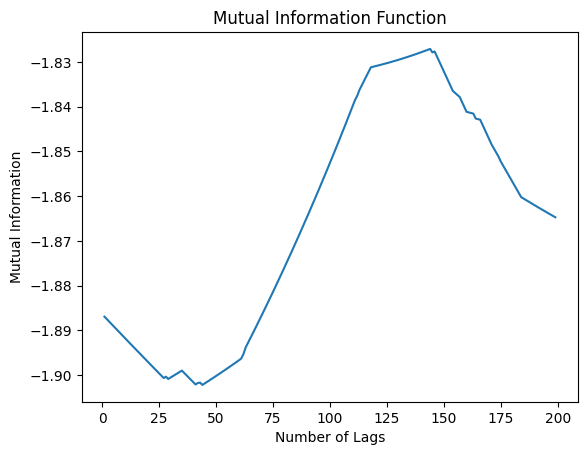

In [8]:
# Define function to compute univariate discrete probability function
def univariate_pd(x, bins: int):
    lenght = (max(x)-min(x))/bins
    count = [0]*bins
    intervals = [min(x)+lenght*i for i in range(1,bins+1)]
    for k in x:
        c = 0
        for i in range(1,len(intervals)):
            if k < intervals[i]:
                c += 1
            else:
                pass
        count[c] += 1
    return intervals, np.array([count[i]/len(x) for i in range(len(count))])

# Define function to compute bivariate discrete probability function
def bivariate_pd(x, y, bins:int):
    lenght_x, lenght_y= (max(x)-min(x))/bins, (max(y)-min(y))/bins
    count_x = count_y = [0]*bins
    intervals_x, intervals_y = [min(x)+lenght_x*i for i in range(1,bins+1)], [min(y)+lenght_y*i for i in range(1,bins+1)]
    for k in x:
        c = 0
        for i in range(1,len(intervals_x)):
            if k < intervals_x[i]:
                c += 1
            else:
                pass
        count_x[c] += 1
    count_x = np.array([count_x[i]/len(x) for i in range(len(count_x))])
    for k in y:
        c = 0
        for i in range(1,len(intervals_y)):
            if k < intervals_y[i]:
                c += 1
            else:
                pass
        count_y[c] += 1
    count_y = np.array([count_y[i]/len(x) for i in range(len(count_y))])
    return np.outer(count_x, count_y)

def mutual_info(x, lags, bins):
    for lag in range(1,lags):
        pd_xy = bivariate_pd(x[:-lag].numpy(), x.roll(-lag)[:-lag].numpy(), bins)
        intervals, pd_x = univariate_pd(x.numpy(), bins)
        mif.append(np.sum(pd_xy*np.log(pd_xy))-2*np.sum(pd_x*np.log(pd_x)))
    return mif
mif = []
lags = 200
bins = 10
mif = mutual_info(torch.tensor(normalized_data), lags, bins)
plt.plot(range(1,lags), mif)
plt.xlabel('Number of Lags')
plt.ylabel('Mutual Information')
plt.title('Mutual Information Function')
plt.savefig('MIF daily normalized NASDAQ.png')

#### Determine optimal lags using local minimas of MIF

In [9]:
# Define simple function to compute argmins of Mutual Information Function
def argmin(x:Union[list,np.array]):
    argmin = []
    for i in range(1,len(mif)-1):
        if mif[i-1] > mif[i] and mif[i] < mif[i+1]:
            argmin.append(i)
    return argmin
opt_lags = argmin(mif)
opt_lags

[26, 28, 40, 43, 144]

### Determine dimension of embedding space

### False Nearest Neighbors Test

In [10]:
from math import ceil
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Define function to create delay vector
def delay_vector(x:np.array, tao, dim):
    delay = []
    for j in range(1,len(x)-tao*dim + tao + 1):
        k = []
        for i in range(dim):
            k.append(x[-1-i*tao])
        x = x[:-1]
        delay.append(k[::-1])
    return np.array(delay[::-1])

# Define Euclidean Distance suitable for the specific data structure of the algorithm
def dist(x:np.array):
        return np.sum((x[:,0]-x[:,1])**2, axis=1)

# Define False Neighbors function to retrieve False Neighbors value for each dimension
def False_Neighbors(x:np.array, R_tol:float = 0.1, d_max:int = 25):
    # Initialize neighbors
    v = delay_vector(x, 1, 2)
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='kd_tree').fit(v[:len(x)-d_max])
    distances, indices = nbrs.kneighbors(v[:len(x)-d_max])
    fn = []
    for current_d in range(3,d_max):
        previous_v = delay_vector(x, 1, current_d-1)
        next_v = delay_vector(x, 1, current_d)
        false_neighbors = (dist(next_v[indices])-dist(previous_v[indices]))/dist(previous_v[indices]) > R_tol
        fn.append(np.sum(false_neighbors)/len(indices))
    return fn

#### Plot FNN result

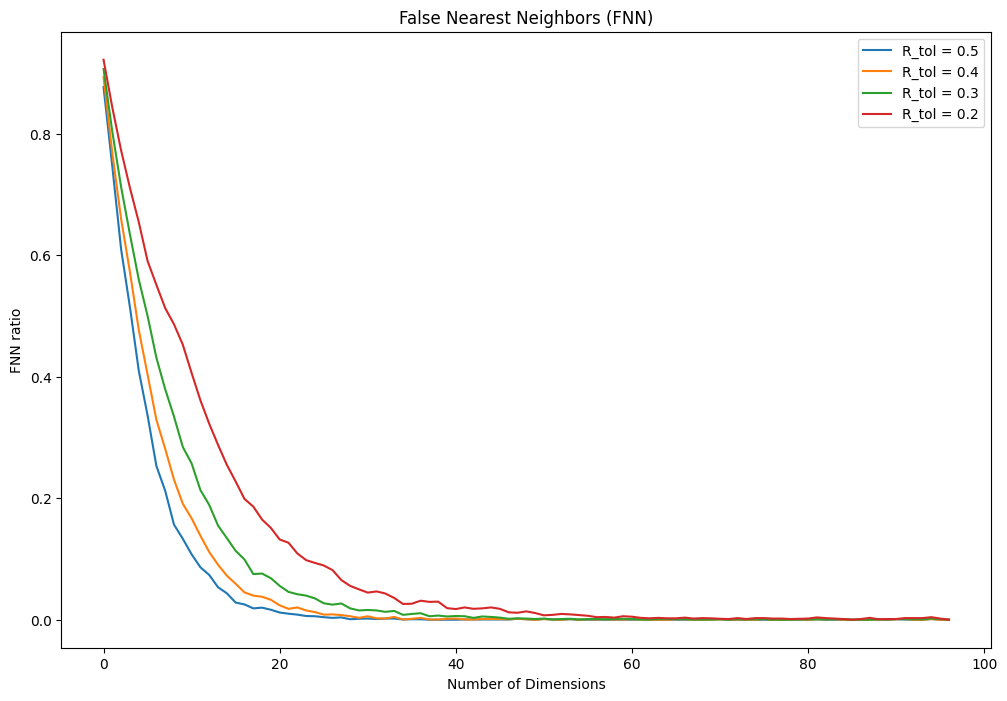

In [12]:
plt.figure(figsize=(12,8))
for R_tol in [0.5,0.4,0.3,0.2]:
    plt.plot(False_Neighbors(torch.tensor(close), R_tol, 100), label = f'R_tol = {R_tol}')
plt.legend()
plt.xlabel('Number of Dimensions')
plt.ylabel('FNN ratio')
plt.title('False Nearest Neighbors (FNN)')
# plt.savefig('../img/FNN')
plt.show()